# Cleaner class example (LEVEL 0)

The Cleaner class can be initialised and used to perform similar activities to the autoprocessing functionality.

It relies on the definition of the instruments described in the [README.md](https://github.com/EERL-EPFL/helikite-data-processing?tab=readme-ov-file#the-instrument-class) to perform the instantiation.

What happens in this first cell is we define where the input data resides, we instantiate the Cleaner class into a variable `cleaner`, which will scan for the files, load them into memory and allow us to work on all of the instruments in bulk.

The functions used to clean the data and perform corrections are all specific to the `Instrument` and can be modified according to the definitions in the Instrument class. For an example, we can see the Flight Computer's instructions code in [the repository](https://github.com/EERL-EPFL/helikite-data-processing/blob/main/helikite/instruments/flight_computer.py). Editing this file and reloading the environment will alter its behaviour in this script.

Let's get started!

In [1]:
from helikite import Cleaner, instruments
import os
import datetime

# The folder where the data resides. In this example, it is in the folder
# 'rawdata' in relation to where we loaded jupyter lab from.
INPUT_DATA = os.path.join(os.getcwd(), "rawdata")  

# Initialise the Cleaner class, scan the input data folder and import
cleaner = Cleaner(
    instruments=[
        instruments.flight_computer_v1,  # These are the classes of the instruments 
        instruments.smart_tether,     # that contain all the functions to process
        instruments.pops,             # each one. Add more or remove according to 
        instruments.msems_readings,   # the flight
        instruments.msems_inverted,
        instruments.msems_scan,
        instruments.stap,
    ], 
    reference_instrument=instruments.flight_computer_v1,  # We need a reference, in this flight it is the flight computer
    input_folder=INPUT_DATA,
    flight_date=datetime.date(2024,4,2),
    # time_trim_from=datetime.datetime(2024,4,2,9,45,15),  # These are commented out as we can do this interactively below
    # time_trim_to=datetime.datetime(2024,4,2,13,10),      # If you know them already, you can add them here as datetime objects
    time_offset=datetime.time(0),                          # If there is a time_offset to apply, it can be defined here
)

Helikite Cleaner has been initialised with 7 instruments. Use the .state() method to see the current state, and the .help() method to see the available methods.


# Checking state

Ok! Our class is now instantiated. The class looked at our input directory and guessed the files based on their `file_identifier()` method in their respective classes, as it happens if used from the CLI or Docker!

There are no errors, so we can assume the raw CSVs have been loaded into memory according to how they are instructed to be read by the `read_data()` method in each instrument class. Each instrument can be accessed now with `cleaner.<instrument_name>` and it will have two pandas dataframes available as `.df` which will hold our data as we progress through any corrections, and a copy of it in `.df_raw` that will not be changed. 

These dataframes can both be used as you wish, as if you loaded them directly with pandas. If you want, you can stop here, and use them as if you imported them manually. 

In [2]:
# Here's an example
cleaner.flight_computer.df

SBI    DateTime  PartCon     CO2   P_baro  TEMPbox mFlow  TEMPsamp  \
0       $  1712051115     <NA>   10.26  1015.34    18.69   NaN     17.27   
1       $  1712051116     <NA>   12.21  1015.34    18.69   NaN     17.27   
2       $  1712051117     <NA>   14.17  1015.34    18.75   NaN     17.26   
3       $  1712051118     <NA>   15.88  1015.32    18.75   NaN     17.27   
4       $  1712051119     <NA>   17.34  1015.33    18.75   NaN      17.3   
...    ..         ...      ...     ...      ...      ...   ...       ...   
12345   $  1712063458       33  336.35   1014.9    10.38   NaN      9.84   
12346   $  1712063458       33  336.59  1014.86    10.38   NaN      9.84   
12347   $  1712063460       33  336.59   1014.9    10.38   NaN      9.86   
12348   $  1712063461       46  336.59  1014.81    10.38   NaN      9.83   
12349   $  1712063462       46  336.59  1014.93    10.38   NaN      9.86   

       RHsamp  TEMP1    RH1  TEMP2    RH2   vBat  
0        9.79  15.81   12.0  15.92  11.93  24.83  
1        9.81   15.8  12.05  15.93  11.87  24.83  
2        9.79   15.8  12.02  15.89  11.92  24.82  
3        9.82  15.75   12.0  15.88  11.92  24.81  
4        9.76  15.75  12.03  15.86  11.98  24.81  
...       ...    ...    ...    ...    ...    ...  
12345   12.82   9.59  18.18   9.01   19.1  22.27  
12346    12.8   9.64  18.07   9.05  18.93  22.29  
12347   12.85   9.68  17.97   9.06  18.87  22.29  
12348    12.8   9.74  17.83   9.12  18.71  22.26  
12349   12.82   9.78   17.8   9.16  18.63  22.25  

[12350 rows x 14 columns]

### Wait..
But that's no fun, right? Let's try to make it a bit easier for ourselves! At least we know we are not bound by the capabilities of our library if we want to explore the data differently.

The function .state() is now available to give a summary about how our class is managing our data. It can be used at any stage throughout the cleaning process to help us know what's happening inside of `cleaner`.

In [3]:
# Let's see what it says now...
cleaner.state()

Instrument          Records   Reference 
----------------------------------------
flight_computer     12350     Yes       
smart_tether        11384     No        
pops                12303     No        
msems_readings      12342     No        
msems_inverted      67        No        
msems_scan          67        No        
stap                12347     No        


Property                 Value                         
-------------------------------------------------------
Input folder             /home/ejthomas/projects/EERL/Helikite/helikite-data-processing/notebooks/rawdata
Flight date              2024-04-02
Time trim from           None                          
Time trim to             None                          
Time offset              00:00:00                      
Pressure column          housekeeping_pressure         
Master dataframe         Not available                 
Housekeeping dataframe   Not available                 
Selected pressure points Not available 

### "No operations have been completed"

What does that mean? Well, we can only perform some of these functions in a specific order, because they are mutating the data. We cannot perform them twice, and some require others to run before they can work on the next step. These are defined with a function decorator to define their dependencies in the `Cleaner` class, and the class tracks which ones have been executed. So as we progress we can see what we have done, if we execute a method that requires something prior, it will not work.

So what can we do? Let's check what methods are available for us to continue with `.help()`

Take note in each description, we can see what needs to be run first, and if that function can only execute once.

In [4]:
cleaner.help()


There are several methods available to clean the data:
- apply_rolling_window_to_pressure(window_size: int = 20)
	Apply rolling window to the pressure measurements of each instrument
	Dependencies: merge_instruments, set_pressure_column, set_time_as_index, correct_time, remove_duplicates
	Note: Can only be run once
- correct_time(trim_start: pandas._libs.tslibs.timestamps.Timestamp | None = None, trim_end: pandas._libs.tslibs.timestamps.Timestamp | None = None) -> None
	Corrects the time of each instrument based on the time offset
	Dependencies: set_time_as_index
	Note: Can only be run once
- correct_time_and_pressure(max_lag=180)
	Correct time and pressure for each instrument based on time lag.
	Dependencies: set_time_as_index, data_corrections, set_pressure_column
- data_corrections(start_altitude: float = None, start_pressure: float = None, start_temperature: float = None) -> None
	No docstring available.
	Dependencies: set_time_as_index
	Note: Can only be run once
- define_flight_

In [6]:
# So if we try to run a function that has some dependencies, we will be told we cannot 
cleaner.correct_time_and_pressure(max_lag=180)

This function 'correct_time_and_pressure()' requires the following operations first: set_time_as_index(), data_corrections(), set_pressure_column().


In [3]:
# Let's try again, after performing the corrections
cleaner.set_time_as_index()
cleaner.data_corrections()
cleaner.set_pressure_column()

2024-11-27 08:55:32,111 [INFO   ] No defined ground station pressure. Using estimate from first 10 seconds of data. Calculated to: 1015.3 (Flight Computer: P_baro)
2024-11-27 08:55:32,111 [INFO   ] No defined ground station temperature. Using estimate from first 10 seconds of data. Calculated to: 15.74 (Flight Computer: TEMP1)
2024-11-27 08:55:32,112 [INFO   ] Altitude at start set to: 0


Set time as index for (7/7): flight_computer, smart_tether, pops, msems_readings, msems_inverted, msems_scan, stap
Errors (0/7):
Set data corrections for (7/7): flight_computer, smart_tether, pops, msems_readings, msems_inverted, msems_scan, stap
Errors (0/7):
Set pressure column for (7/7): flight_computer, smart_tether, pops, msems_readings, msems_inverted, msems_scan, stap
Errors (0/7):


# Setting our flight times

Now that the necessary functions have been executed to get the dataframes cleaned, we can try to set our flight times. We can do this interactively, by clicking on a time to start, then again on the end time (and if there's a mistake, to click on the first time again). All instruments are plotted, but we can only select the time from our reference instrument, which we set in the beginning as the `flight_computer`. We can zoom in to the plot to pick a good point

In [13]:
cleaner.define_flight_times()

Note: msems_inverted does not have a pressure column
Callback attached to trace: flight_computer


    'data': [{'line': {'color': 'red', 'width': 2},
              'name': 'fligh…

# Correct time and pressure based on time lag
Let's correct the instruments based on their time lag to the reference instrument and plot the pressure to see the result.

No pressure column
Instrument: smart_tether | Max val 0.999604344902073 @ idx: -94
Shifting smart_tether_ by -94 index
Instrument: pops | Max val 0.9999827042448793 @ idx: -82
Shifting pops_ by -82 index
Instrument: msems_readings | Max val 0.994223245997587 @ idx: -5
Shifting msems_readings_ by -5 index
No pressure column
Instrument: msems_scan | Max val 0.9938366267749229 @ idx: 8
Shifting msems_scan_ by 8 index
Instrument: stap | Max val 0.9996317547986586 @ idx: -96
Shifting stap_ by -96 index


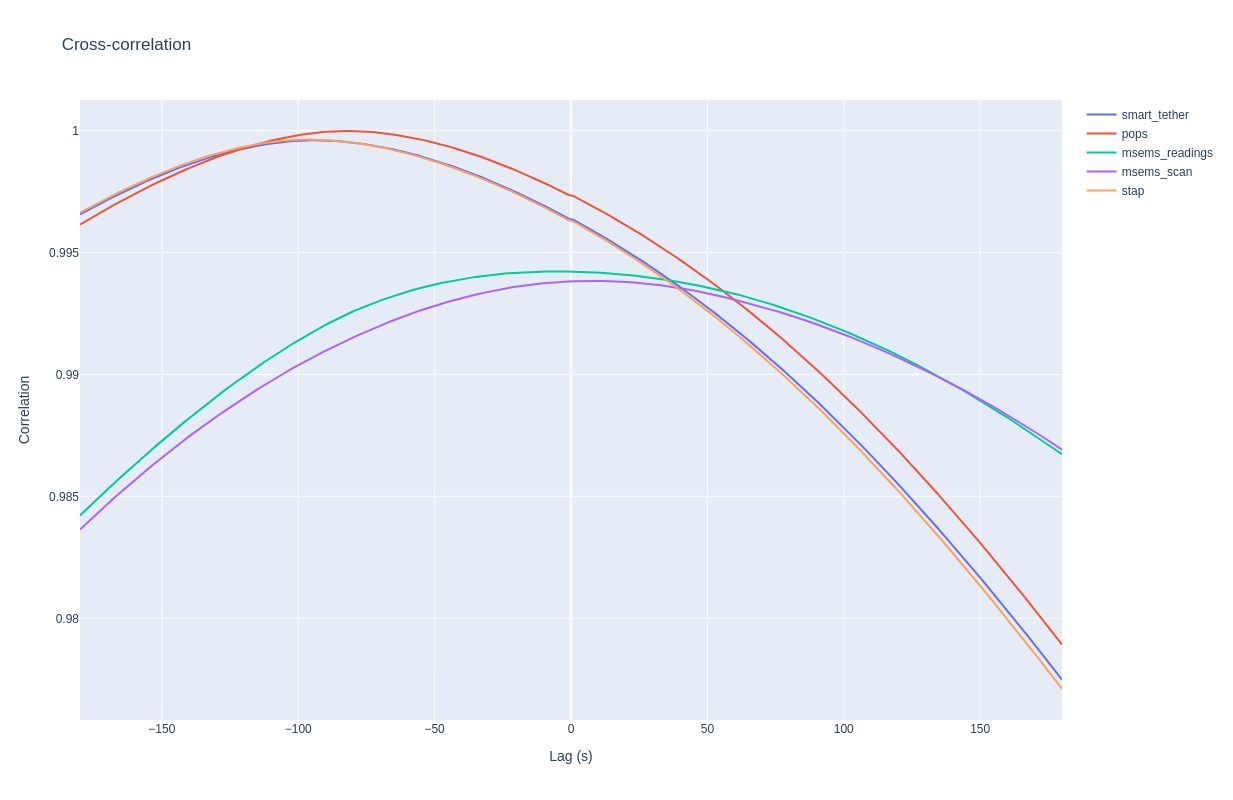

Note: msems_inverted does not have a pressure column


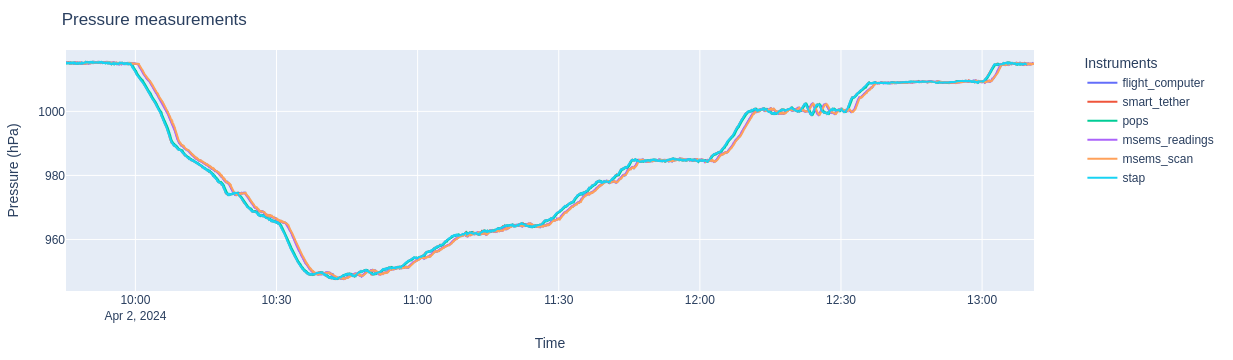

In [6]:
cleaner.correct_time_and_pressure(max_lag=180)
cleaner.plot_pressure()

In [8]:
# Depending on preference, this could happen earlier
cleaner.remove_duplicates()

2024-11-27 08:58:27,400 [INFO   ] Duplicates removed from flight_computer: 0
2024-11-27 08:58:27,407 [INFO   ] Duplicates removed from smart_tether: 0
2024-11-27 08:58:27,415 [INFO   ] Duplicates removed from pops: 0
2024-11-27 08:58:27,421 [INFO   ] Duplicates removed from msems_readings: 0
2024-11-27 08:58:27,428 [INFO   ] Duplicates removed from msems_inverted: 0
2024-11-27 08:58:27,437 [INFO   ] Duplicates removed from msems_scan: 0
2024-11-27 08:58:27,443 [INFO   ] Duplicates removed from stap: 0


Set duplicate removal for (7/7): flight_computer, smart_tether, pops, msems_readings, msems_inverted, msems_scan, stap
Errors (0/7):


In [9]:
cleaner.state()

Instrument          Records   Reference 
----------------------------------------
flight_computer     11010     Yes       
smart_tether        11010     No        
pops                11010     No        
msems_readings      11010     No        
msems_inverted      60        No        
msems_scan          11010     No        
stap                11010     No        


Property                 Value                         
-------------------------------------------------------
Input folder             /home/ejthomas/projects/EERL/Helikite/helikite-data-processing/notebooks/rawdata
Flight date              2024-04-02
Time trim from           2024-04-02 10:00:35           
Time trim to             2024-04-02 13:04:04           
Time offset              00:00:00                      
Pressure column          housekeeping_pressure         
Master dataframe         Not available                 
Housekeeping dataframe   Not available                 
Selected pressure points 0             

In [10]:
# Merge the instruments, they will become available in cleaner.master_df
cleaner.merge_instruments()

Added instrument names to columns in their respective dataframes (without modifying originals).
Instruments will be merged together with this column order:
	flight_computer_Altitude
	flight_computer_Altitude_agl
	flight_computer_P_baro
	flight_computer_CO2
	flight_computer_TEMP1
	flight_computer_TEMP2
	flight_computer_TEMPsamp
	flight_computer_RH1
	flight_computer_RH2
	flight_computer_RHsamp
	flight_computer_mFlow
	pops_P
	pops_PartCon_186
	pops_POPS_Flow
	pops_b0
	pops_b1
	pops_b2
	pops_b3
	pops_b4
	pops_b5
	pops_b6
	pops_b7
	pops_b8
	pops_b9
	pops_b10
	pops_b11
	pops_b12
	pops_b13
	pops_b14
	pops_b15
	stap_sample_press_mbar
	stap_sample_temp_C
	stap_sigmab
	stap_sigmag
	stap_sigmar
	stap_sigmab_smth
	stap_sigmag_smth
	stap_sigmar_smth
	smart_tether_Comment
	smart_tether_P (mbar)
	smart_tether_T (deg C)
	smart_tether_%RH
	smart_tether_Wind (degrees)
	smart_tether_Wind (m/s)
	smart_tether_UTC Time
	smart_tether_Latitude (deg)
	smart_tether_Longitude (deg)
The master dataframe has been 

# Check our merge

As noted, we can look at the master dataframe in the `cleaner.master_df` variable.

In [11]:
cleaner.master_df

flight_computer_SBI  flight_computer_PartCon  \
DateTime                                                           
2024-04-02 10:00:35                   $                      122   
2024-04-02 10:00:36                   $                      116   
2024-04-02 10:00:37                   $                      116   
2024-04-02 10:00:38                   $                      113   
2024-04-02 10:00:39                   $                      113   
...                                 ...                      ...   
2024-04-02 13:04:04                   $                      110   
2024-04-02 13:04:04                   $                      110   
2024-04-02 13:04:04                   $                      110   
2024-04-02 13:04:04                   $                      110   
2024-04-02 13:04:04                   $                      110   

                     flight_computer_CO2  flight_computer_P_baro  \
DateTime                                                           
2024-04-02 10:00:35               292.38                 1014.85   
2024-04-02 10:00:36               292.62                 1014.81   
2024-04-02 10:00:37               292.62                 1014.78   
2024-04-02 10:00:38               292.62                 1014.66   
2024-04-02 10:00:39               293.11                 1014.69   
...                                  ...                     ...   
2024-04-02 13:04:04               336.83                  1014.6   
2024-04-02 13:04:04               336.83                  1014.6   
2024-04-02 13:04:04               336.83                  1014.6   
2024-04-02 13:04:04               336.83                  1014.6   
2024-04-02 13:04:04               336.83                  1014.6   

                     flight_computer_TEMPbox flight_computer_mFlow  \
DateTime                                                             
2024-04-02 10:00:35                    19.44                   NaN   
2024-04-02 10:00:36                    19.44                   NaN   
2024-04-02 10:00:37                    19.44                   NaN   
2024-04-02 10:00:38                    19.38                   NaN   
2024-04-02 10:00:39                    19.38                   NaN   
...                                      ...                   ...   
2024-04-02 13:04:04                    10.06                   NaN   
2024-04-02 13:04:04                    10.06                   NaN   
2024-04-02 13:04:04                    10.06                   NaN   
2024-04-02 13:04:04                    10.06                   NaN   
2024-04-02 13:04:04                    10.06                   NaN   

                     flight_computer_TEMPsamp  flight_computer_RHsamp  \
DateTime                                                                
2024-04-02 10:00:35                     18.74                    8.44   
2024-04-02 10:00:36                     18.73                    8.44   
2024-04-02 10:00:37                     18.73                    8.37   
2024-04-02 10:00:38                     18.74                    8.42   
2024-04-02 10:00:39                     18.74                    8.42   
...                                       ...                     ...   
2024-04-02 13:04:04                      9.83                   11.01   
2024-04-02 13:04:04                      9.83                   11.01   
2024-04-02 13:04:04                      9.83                   11.01   
2024-04-02 13:04:04                      9.83                   11.01   
2024-04-02 13:04:04                      9.83                   11.01   

                     flight_computer_TEMP1  flight_computer_RH1  ...  \
DateTime                                                         ...   
2024-04-02 10:00:35                 -15.48                61.28  ...   
2024-04-02 10:00:36                 -15.48                61.29  ...   
2024-04-02 10:00:37                 -15.48                 61.3  ...   
2024-04-02 10:00:38          

In [12]:
cleaner.export_data()


Done.
	Dataframes have been exported to CSV files.
	The file 'master.csv' contains the data columns
	The file 'housekeeping.csv' contains the housekeeping columns.
	The column order is determined by the export_order attribute.
	The order of the instruments is determined by the export order defined in each instrument's class.
